In [18]:
import numpy as np
from scipy.io import wavfile
from numpy.fft import fft, ifft, fftshift
import librosa 
import librosa.display
from scipy.io.wavfile import write
import sounddevice as sd
import soundfile as sf
import time
import matplotlib.pyplot as plt
from scipy.signal import hann

In [9]:
sampleing_rate = 16000
carrier_frequency = 880
modulator_frequency = 220
duration_s = 1
amplitude= 1
modulation_index = 2

In [10]:
total_sample = np.arange(duration_s * sampleing_rate)

# Create the term that create the carrier
carrier = 2 * np.pi * total_sample * carrier_frequency / sampleing_rate

# Now create the term that is the frequency modulator
modulator = modulation_index * np.sin(2 * np.pi * total_sample * modulator_frequency / sampleing_rate)
waveform = amplitude*np.sin(carrier + modulator)

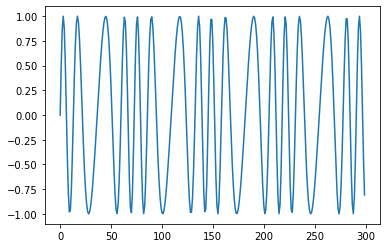

In [11]:
plt.plot(waveform[0:300])

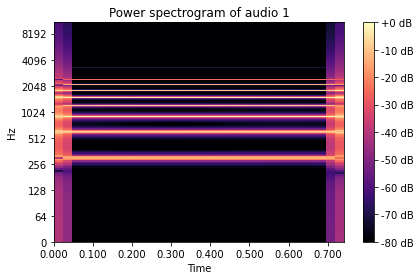

In [15]:
spectrogram_librosa = librosa.stft(waveform)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(spectrogram_librosa),ref=np.max),y_axis='log', x_axis='time')
plt.title('Power spectrogram of audio 1')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()
sd.play(waveform, sampleing_rate)
sd.wait()

In [22]:
def princarg(phase_in):
  """
  Computes principle argument,  wraps phase to (-pi, pi]
  """
  phase = np.mod(phase_in + np.pi,-2*np.pi)+np.pi;
  return phase
  



def delta_phi_(Phase_current, Phase_previous, winHopAn, wLen):
    """
    Function for calculating unwrapped phase difference between consecutive frames
    
    Phase_current: current frame phase
    Phase_previous: previous frame phase
    winHopAn: Analysis hop length
    wLen: window length
    """
    
    # nominal phase increment for the analysis hop size for each bin
    omega = 2*np.pi*(winHopAn/wLen)*np.arange(0, wLen)
    delta_phi = omega + princarg(Phase_current-Phase_previous-omega)
    return delta_phi
    

In [25]:
epsilon = sys.float_info.epsilon # small positive value to avoid zeros inside the log

# read audio
#s,sr = sf.read(audio_0)
#sd.play(waveform, sampleing_rate)
#sd.wait()
s = waveform
fs = sampleing_rate

audioOut = np.zeros(len(s))        # placeholder for reconstructed audio
wLen = int(0.032*fs)                   # window length
winAn = np.sqrt(hann(wLen, sym=False)) # analysis window
winSyn =winAn


winHopAn = int(0.008*fs)             # Hop length or frame advance
winHopSyn = int(0.0112*fs)
ratio = 1.4
inInd = 0
phi0_prev = 0
syn_prev = 0

while inInd< len(s)-wLen:

  # selct the frame and multiply with window function
  frame = s[inInd:inInd+wLen]* winAn 
  
  # compute DFT
  f = fft(frame)
  
  # save magnitudes and phases
  mag_f = np.abs(f)
  phi0 = np.angle(f) 

  delta_phi = delta_phi_(phi0,phi0_prev,winHopAn, wLen)
  syn_new = syn_prev + ratio*delta_phi 
  # When synthesizing, the time stretching will lead to phase mismatch. Therefore you need to stretch the phase as well when synthesizing.
  
  syn_wrap = princarg(syn_new)

  # Updating previous values for next loop
  syn_prev = syn_wrap
  phi0_prev = phi0

  
  # Recover the complex FFT back
  ft = (abs(f)* np.exp(1j*syn_wrap))  
  
  # inverse DFT and windowing
  frame = np.real(ifft(ft))*winSyn
  
  # Ovelap add
  audioOut[inInd :inInd +wLen] =  audioOut[inInd :inInd +wLen] + frame
  
  # frame advance by winHopAn
  inInd = inInd + winHopAn
    

#plot_spectrogram(20*np.log10(power_spectrogram+epsilon))
#plt.title('Fig 3: Logrithmic power spectrogram')

In [26]:
sd.play(waveform, sampleing_rate)
sd.wait()
sd.play(audioOut, sampleing_rate)
sd.wait()

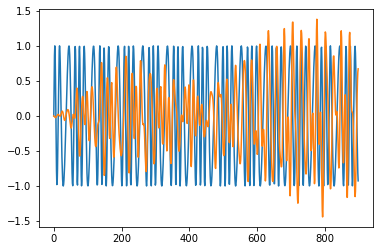

In [28]:
plt.plot(waveform[0:900])
plt.plot(audioOut[0:900])